# Analogous cycles
* This notebook implements the analogous cycles method on the experimentla visual data

In [1]:
using Pkg
Pkg.activate("../../env/.")
Pkg.instantiate()

  Activating project at `~/Documents/analogous_neural/env`


In [3]:
include("../../src/analogous_bars.jl")
include("../../src/Eirene_var.jl")

using .analogous_bars
using .Eirene_var
using DelimitedFiles
using HDF5
using Plots
using FileIO
using MultivariateStats


WebIO._IJuliaInit()

## 1. Load dissimialrity

In [4]:
# load dissimilarity
total_D = readdlm("data/total_dissimilarity.csv")

# get number of neurons in AL
AL_txt = open("data/AL_neurons_idx.txt", "r")
AL_linebyline = readlines(AL_txt)
close(AL_txt)
n_AL = size(AL_linebyline, 1)

# get number of neurons in V1
V1_txt = open("data/V1_neurons_idx.txt", "r")
V1_linebyline = readlines(V1_txt)
close(V1_txt)
n_V1 = size(V1_linebyline, 1)

# Define submatrices 
D_V1 = total_D[1:n_V1, 1:n_V1]
D_AL = total_D[n_V1+1:end, n_V1+1:end]
D_V1_AL = total_D[1:n_V1, n_V1+1:end]
    # rows (landmarks): V1
    # columns (witness) : AL
D_AL_V1 = total_D[n_V1+1:end, 1:n_V1];
    # rows (landmarks): AL
    # columns (witness) : V1

## 2. Run persistence

In [5]:
C_V1 = eirene(D_V1, record = "all", maxdim = 1)
C_AL = eirene(D_AL, record = "all", maxdim = 1)
W_V1 = compute_Witness_persistence(D_V1_AL)

barcode_V1 = barcode(C_V1, dim = 1)
barcode_AL = barcode(C_AL, dim = 1)
barcode_W_V1_AL = barcode(W_V1["eirene_output"], dim = 1);

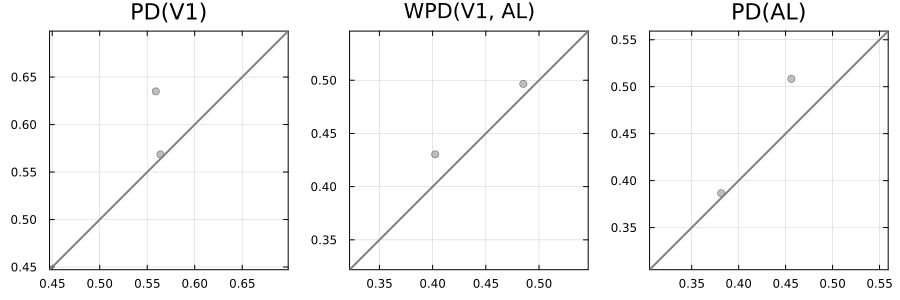

In [6]:
p1 = plot_PD(barcode_V1, title = "PD(V1)", titlefontsize = 15)
p2 = plot_PD(barcode_W_V1_AL, title = "WPD(V1, AL)")
p3 = plot_PD(barcode_AL, title = "PD(AL)", titlefontsize = 15)
plot(p1, p2, p3, layout = grid(1,3), size = (900, 300))

Here, there aren't enough points on the persistence diagrams to do the usual test for significance. 

We therefore compute the significance threshold from randomly generated spike trains.

See notebook "2a_PD_significance_shuffled_spiketrains.ipynb"

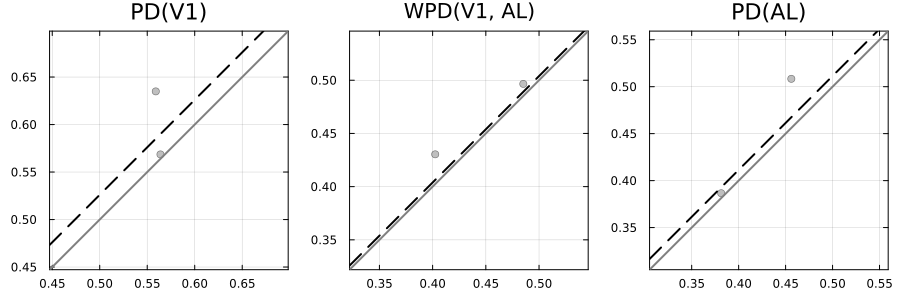

In [7]:
V1_cutoff = 0.026051040622121713
AL_cutoff = 0.011409209171149182
W_cutoff = 0.0038936685376764757



p1 = plot_PD(barcode_V1, title = "PD(V1)", cutoff = V1_cutoff, titlefontsize = 15)
p2 = plot_PD(barcode_W_V1_AL, title = "WPD(V1, AL)", cutoff = W_cutoff)
p3 = plot_PD(barcode_AL, title = "PD(AL)", titlefontsize = 15, cutoff = AL_cutoff)
plot(p1, p2, p3, layout = grid(1,3), size = (900, 300))

## 3. Compute similarity-centric analogous cycles

In [16]:
selected_W_V1_AL = [1,2]
analogous_V1, analogous_AL, W_QP = analogous_bars.run_baseline_similarity_analogous(VR_P = C_V1,
                                                                    D_P = D_V1,
                                                                    VR_Q = C_AL,
                                                                    D_Q = D_AL,
                                                                    W_PQ = W_V1,
                                                                    W_PQ_bars = selected_W_V1_AL,
                                                                    dim = 1);

In [51]:
# note that there are no analgous cycles matched via witness_idx = 1

println("Analogous via witness_idx 1")
println(analogous_V1[1]["baseline_bar_extension"])
println(analogous_AL[1]["baseline_bar_extension"])

Analogous via witness_idx 1
nothing
nothing


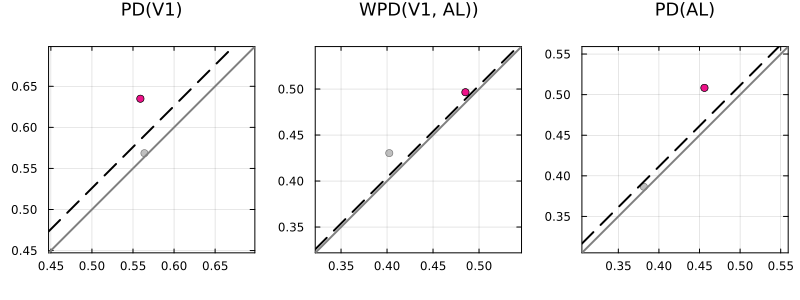

In [20]:
# select Witness bar
witness_idx = 2

# get all barcodes
barcode_VR_V1 = barcode(C_V1, dim = 1)
barcode_VR_AL = barcode(C_AL, dim = 1)
barcode_W_V1_AL = barcode(W_V1["eirene_output"], dim = 1)

# plot all persistence diagrams & significance feature cutoff
selected_V1 =[1,2]
p1 = plot_PD(barcode_VR_V1; 
            cutoff = V1_cutoff,  
            highlight = analogous_V1[witness_idx]["baseline_bar_extension"],
            title = "PD(V1)", 
            titlefontsize = 12)

selected_W_V1_AL = [1,2]
cutoff_W_V1_AL = 0
p2 = plot_PD(barcode_W_V1_AL; 
            cutoff = W_cutoff, 
            highlight = [witness_idx],
            title = "WPD(V1, AL))", 
            titlefontsize = 12)

selected_AL = [1,2]
cutoff_AL = 0
p3 = plot_PD(barcode_VR_AL; 
            cutoff = AL_cutoff, 
            highlight = analogous_AL[witness_idx]["baseline_bar_extension"],
            title = "PD(AL)", 
            titlefontsize = 12)

plot(p1, p2, p3, layout = grid(1,3), size = (800, 300))

In [49]:
analogous_V1[2]["baseline_bar_extension"]

1-element Vector{Int64}:
 2

In [50]:
analogous_AL[2]["baseline_bar_extension"]

1-element Vector{Int64}:
 2

Save the outputs to plot figures in manuscript

In [48]:
save("outputs.jld", "barcode_VR_V1", barcode_VR_V1, "barcode_VR_AL", barcode_VR_AL, "barcode_W", barcode_W_V1_AL,
                    "V1_cutoff", V1_cutoff, "AL_cutoff", AL_cutoff, "W_cutoff", W_cutoff)

### Find cycle representatives of the analogous pair 

In VR(P)

In [39]:
V1_cr = classrep(C_V1, dim = 1, class = 2)

2×11 Matrix{Int64}:
 11  44   8  48   5  52   7  48  52  44   5
  8   7  15  11  20  15  50  20  46  46  50

In [40]:
V1_cr_idx = zeros((size(V1_cr)))
for i = 1:size(V1_cr, 1)
    for j = 1:size(V1_cr, 2)
        V1_cr_idx[i,j] = parse(Int64, V1_linebyline[V1_cr[i,j]])
    end
end

cycle rep: [88, 65, 103, 341, 315, 309, 45, 333, 43, 138, 330]

In VR(Q)

In [43]:
AL_cr = classrep(C_AL, dim = 1, class = 2)

2×5 Matrix{Int64}:
 32  32   7  24  21
 24   7  41  21  41

In [44]:
AL_cr_idx = zeros((size(AL_cr)))
for i = 1:size(AL_cr, 1)
    for j = 1:size(AL_cr, 2)
        AL_cr_idx[i,j] = parse(Int64, AL_linebyline[AL_cr[i,j]])
    end
end

In [45]:
AL_cr_idx

2×5 Matrix{Float64}:
 129.0  129.0   44.0  108.0   99.0
 108.0   44.0  161.0   99.0  161.0

cycle rep: [129, 108, 99, 161, 44]